# Datojen haku ja esikäsittely

In [1]:
from set_path import set_path
mainpath, path = set_path('areadata')

In [2]:
from read_and_prepare_data import read_and_prepare_data
stat, post, kunta_stat, vaalidata = read_and_prepare_data(path)

read_and_prepare_data  read from file
read_post_muncipalities  read from file


In [3]:
from selected_cols import selected_cols
numeric_features, categorical_features = selected_cols(largeset=False, parties=True)

In [4]:
import pandas as pd
import shap
import xgboost as xgb
from sklearn.feature_selection import  mutual_info_classif

from gaussian_model import create_and_draw_best_gaussian_mix
from gaussian_model import create_gaussian_model

from create_prediction import create_prediction
from prepare_and_scale_data import prepare_and_scale_data
from create_prediction import select_kbest
from select_columns_and_clean_data import select_columns_and_clean_data
from draw_all import draw_features

from shap_Xboost import shap_Xboost
from shap_proba_individual import print_reason, print_individual_waterfall
from shap_vals import shap_vals

from print_examples import plot_difference, create_example_df
from create_target_columns import create_target_columns


from draw_and_create_clusters import draw_clusters, display_circles


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_colwidth = 100



n_components = 2
n_clusters = 6
axis_ranks=  [(0,1)]
alpha = 0.8
scaled = True
silhouette_print = 0
covariance_type = 'full'

filename_model_aic = 'aic_cluster'
filename_model_bic = 'bic_cluster'

data, X, test, gmm_bic, gmm_aic = create_and_draw_best_gaussian_mix(filename_model_aic, filename_model_bic, path, stat, stat, numeric_features=numeric_features, categorical_features=categorical_features, scaled=scaled, covariance_type = covariance_type)
data = create_gaussian_model(data, X, gmm_bic)

print(data['cluster'].value_counts())



load model
Silhouette Coefficient: 0.101 Calinski Harabaz Index: 242
2    1059
3    1033
0     491
4     236
1     151
Name: cluster, dtype: int64


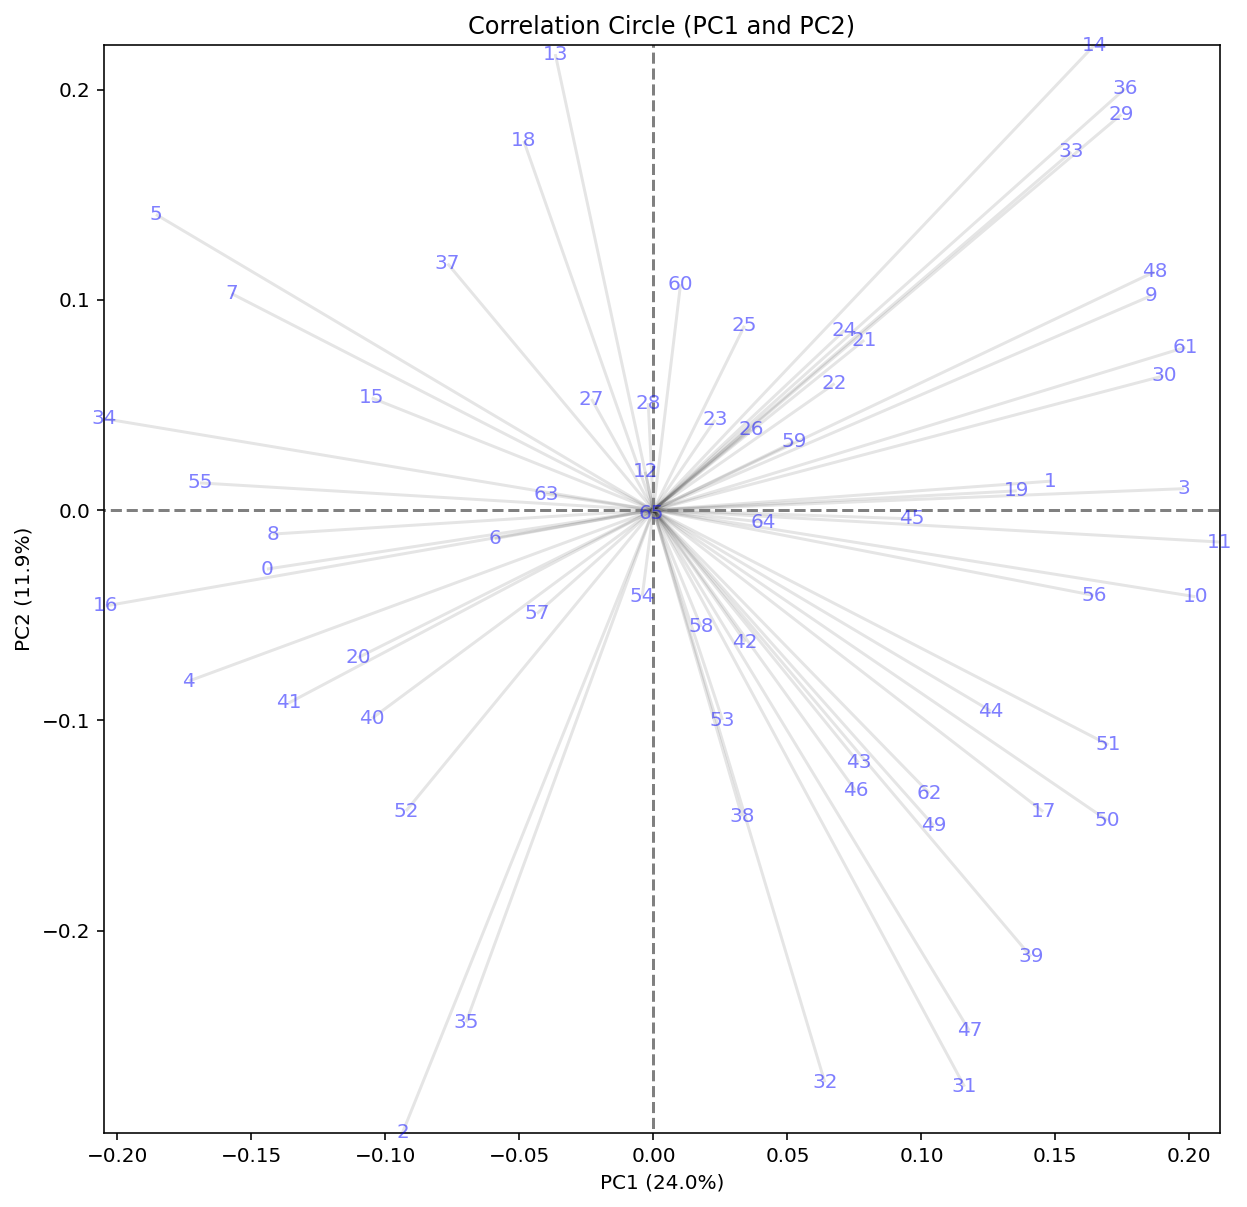

In [7]:
axis_ranks =  [(0,1)]
n_components = 2
labels = [X.columns.get_loc(c) for c in X.columns]

pcs = display_circles(X, n_components=n_components, axis_ranks=axis_ranks, labels=labels, label_rotation=0, lims=None)

In [8]:
for c in X.columns:
    print(X.columns.get_loc(c), c)

0 Miehet, 2018 (HE) osuudesta asukkaat
1 Naiset, 2018 (HE) osuudesta asukkaat
2 Asuntojen keskipinta-ala, 2018 (RA) osuus total
3 Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total
4 Asumisväljyys, 2018 (TE) osuus total
5 Asukkaiden keski-ikä, 2018 (HE) osuus total
6 Postinumeroalueen pinta-ala osuus area_code
7 Perusasteen suorittaneet, 2018 (KO) osuudesta asukkaat
8 Ammatillisen tutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
9 Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
10 Alemman korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
11 Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
12 Asukkaiden ostovoimakertymä, 2017 (HR) osuudesta asukkaat osuus total
13 Asunnot, 2018 (RA) osuudesta asukkaat
14 Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat
15 Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat
16 Pientaloasunnot, 2018 (RA) osuudesta asukkaat
17 Työlliset, 2017 (PT) osuudesta asukkaat
18 Työttömät, 2017 (PT) osuudesta

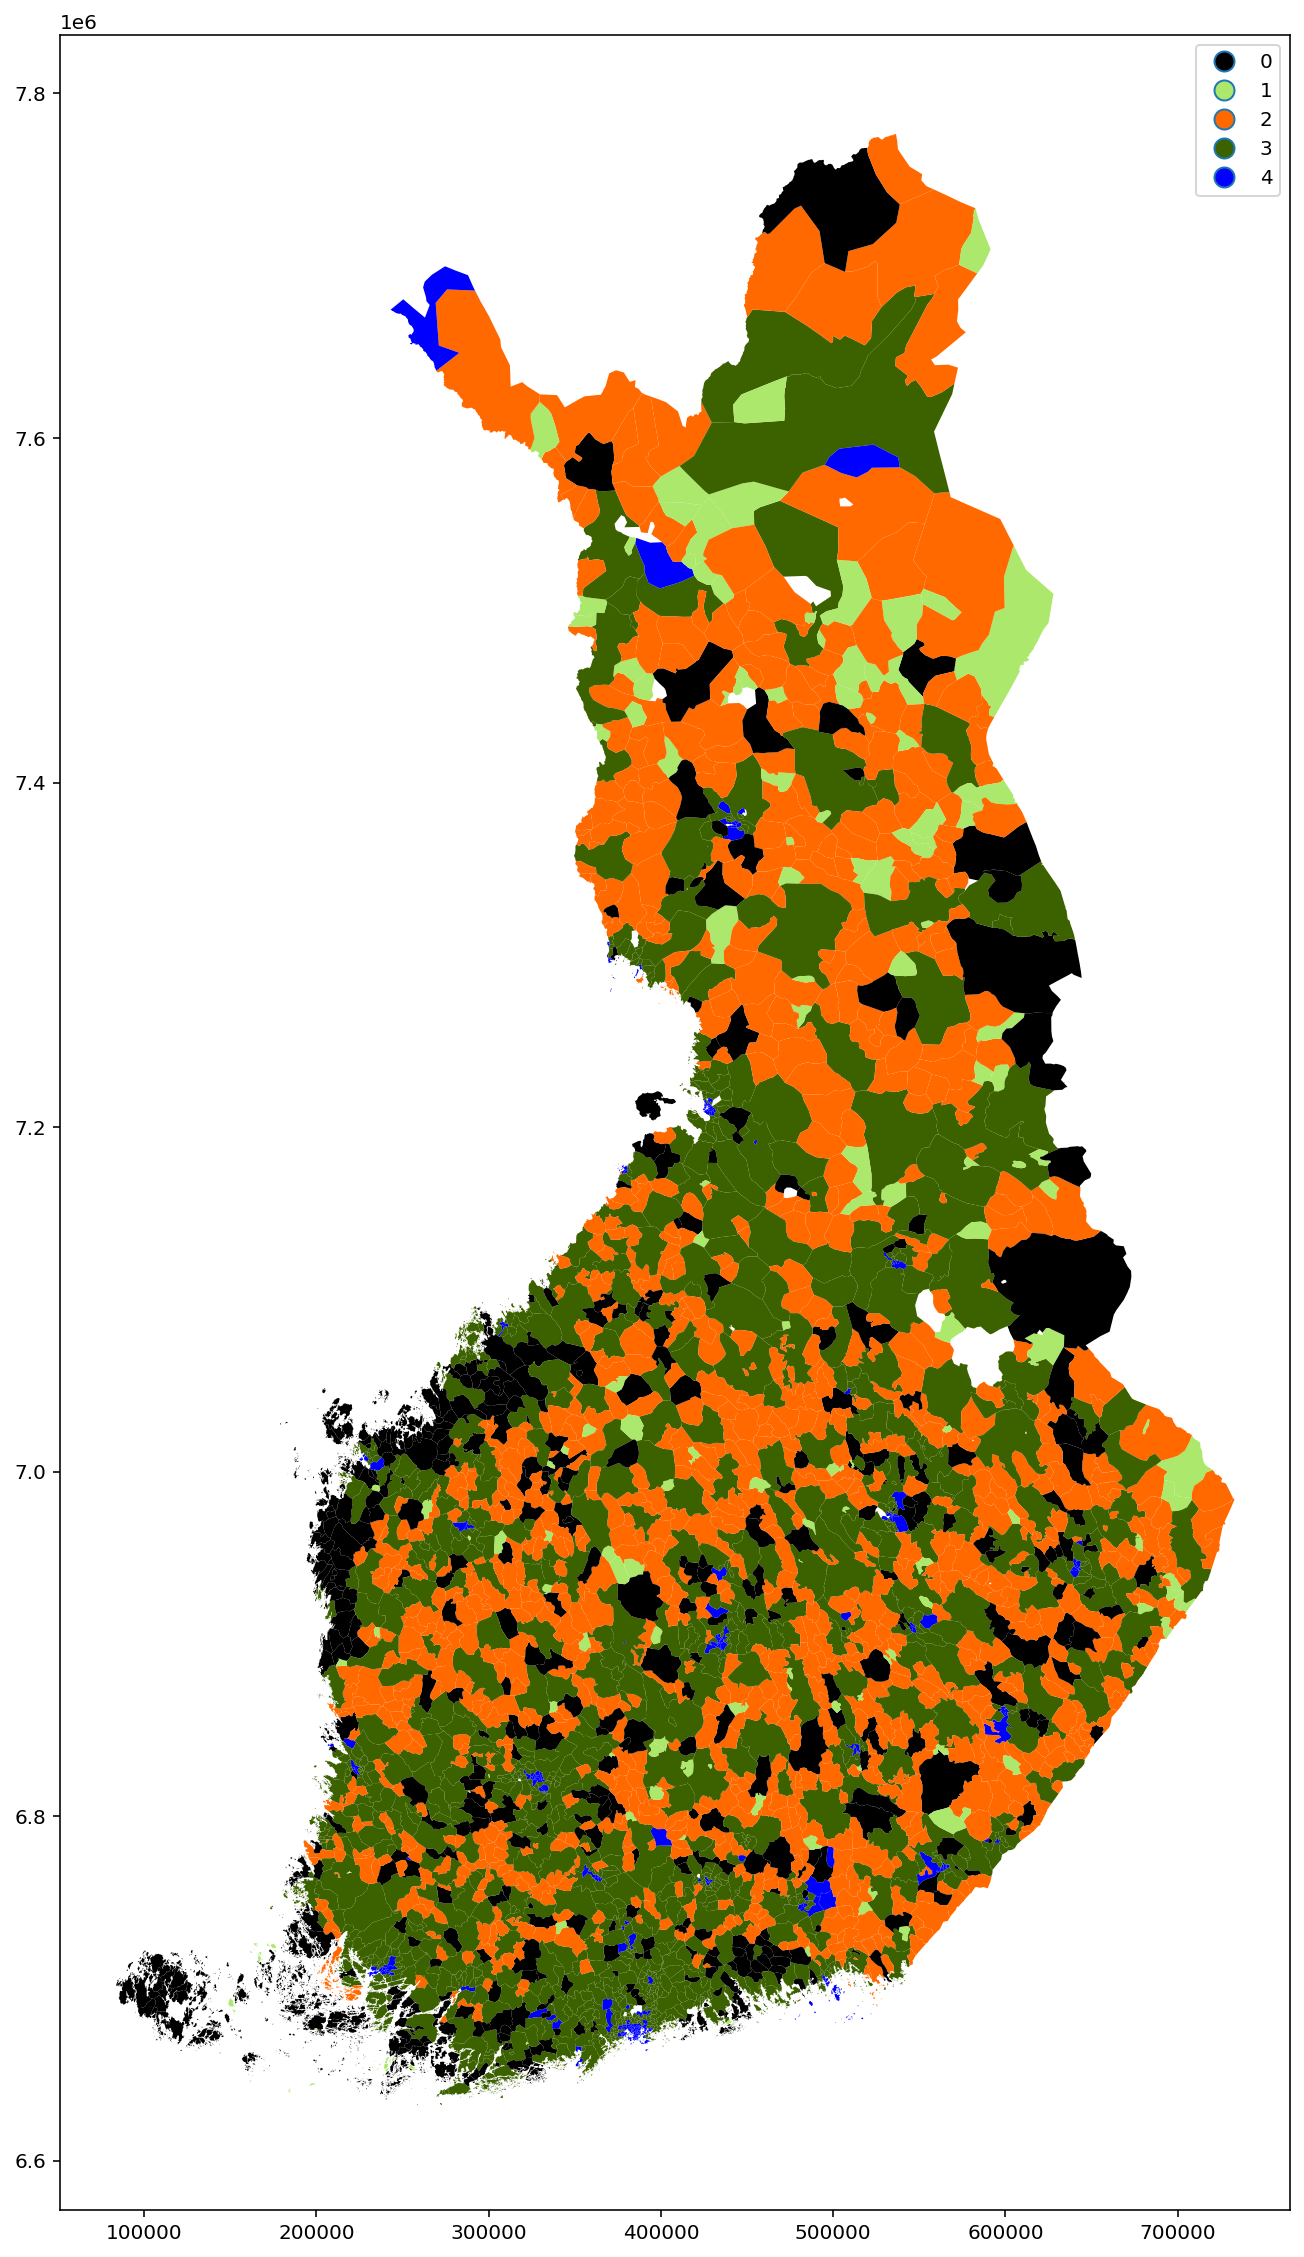

In [9]:
import geopandas
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('my cmap', ['black', 'lightgreen', 'gold',  'red',  'green', 'blue'])
draw = geopandas.GeoDataFrame(pd.DataFrame(data[['cluster', 'geometry']], dtype=object),geometry='geometry')
draw.plot(column='cluster', cmap=cmap, legend=True, figsize=(20,20))

In [10]:
import xgboost as xgb
from sklearn.feature_selection import  mutual_info_classif
from create_prediction import create_prediction

target = 'cluster'

ennustettu = "uusi" + target

#Check
#k_selected need to have correct values, if they are too large, evrything needs to be started again
k_selected = 'all'

test_size = 0.2

#Scalers attributes
kbest_score_func = mutual_info_classif
#set values to model configuration attributes

num_class = len(data['cluster'].unique()) #how many classes we are working with

metric = 'merror'
Skfold=True
Verbose = False
testing=True
scaled = False

params = {
    # Parameters that we are going to tune.
    'objective':'multi:softmax',
    'num_class' : num_class,
    'booster' : 'gbtree',
    'eval_metric' : metric
}

filename_model = 'gauss_xgboost_cluster'
data, test, features_df, importance_df, model, params, y_pred, X_train, y_train, X_test, y_test = create_prediction(filename_model, path, data, data, target, kbest_score_func, metric, params, numeric_features, categorical_features, scaled=scaled, testing=testing)
data_no_use, X_scale, X = prepare_and_scale_data(data, pd.DataFrame(), numeric_features, categorical_features)


load model


In [11]:
filename_model = 'gauss_mymodel_xgboost_cluster'
filename_shap =  'gauss_shap.npz'
mymodel, shap_values, shap_interaction_values, shap_expected_value = shap_Xboost(filename_model, filename_shap, path, data, target, params, X)


load model
load shap files


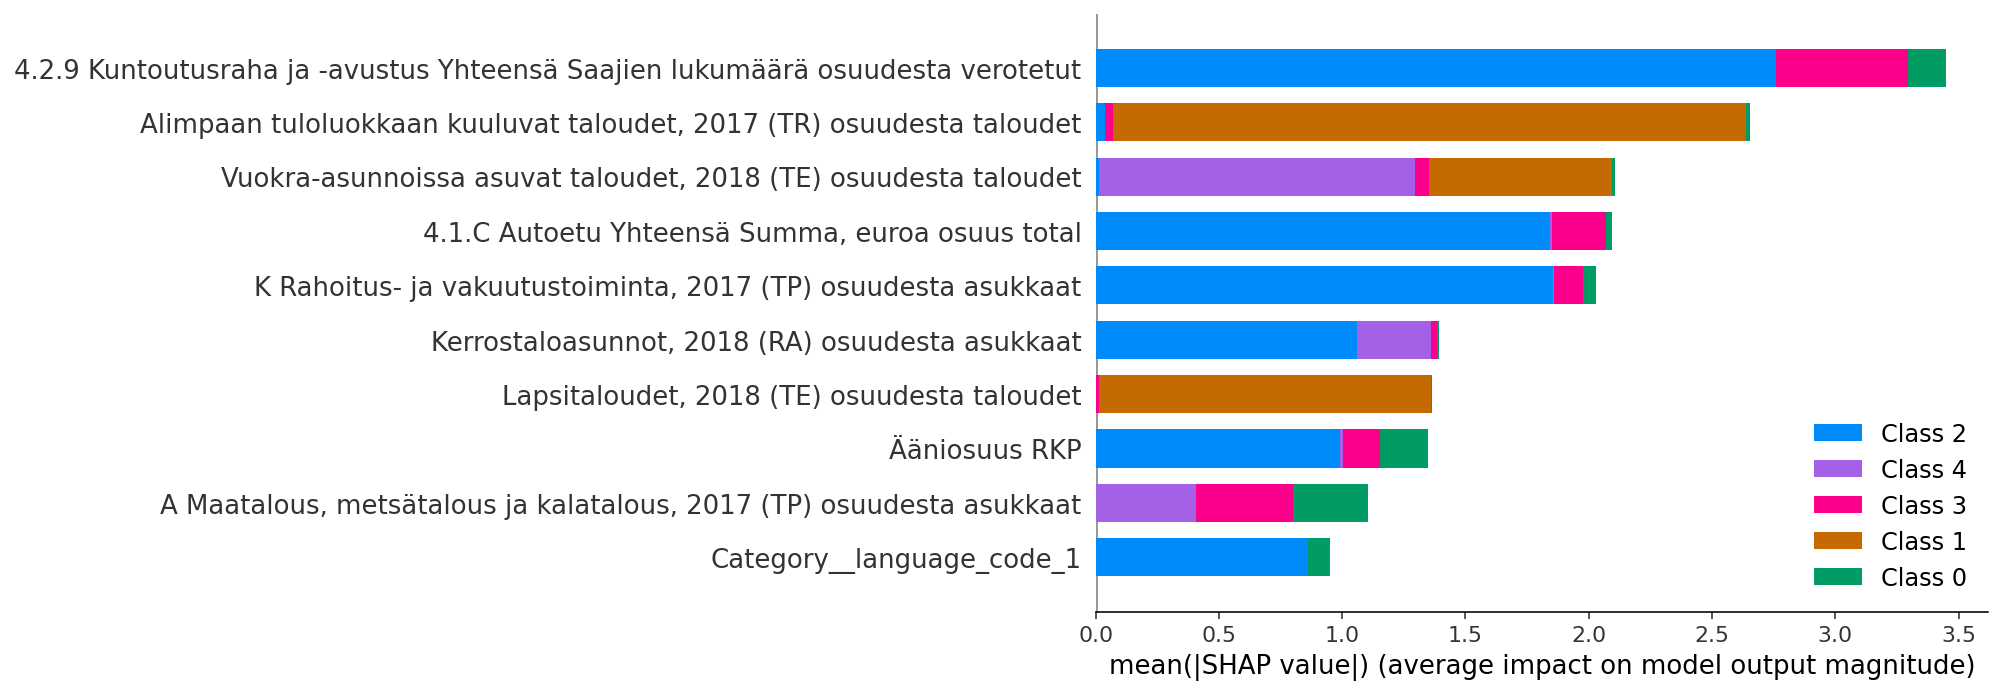

In [12]:
shap.summary_plot(shap_values, X,  max_display=10)

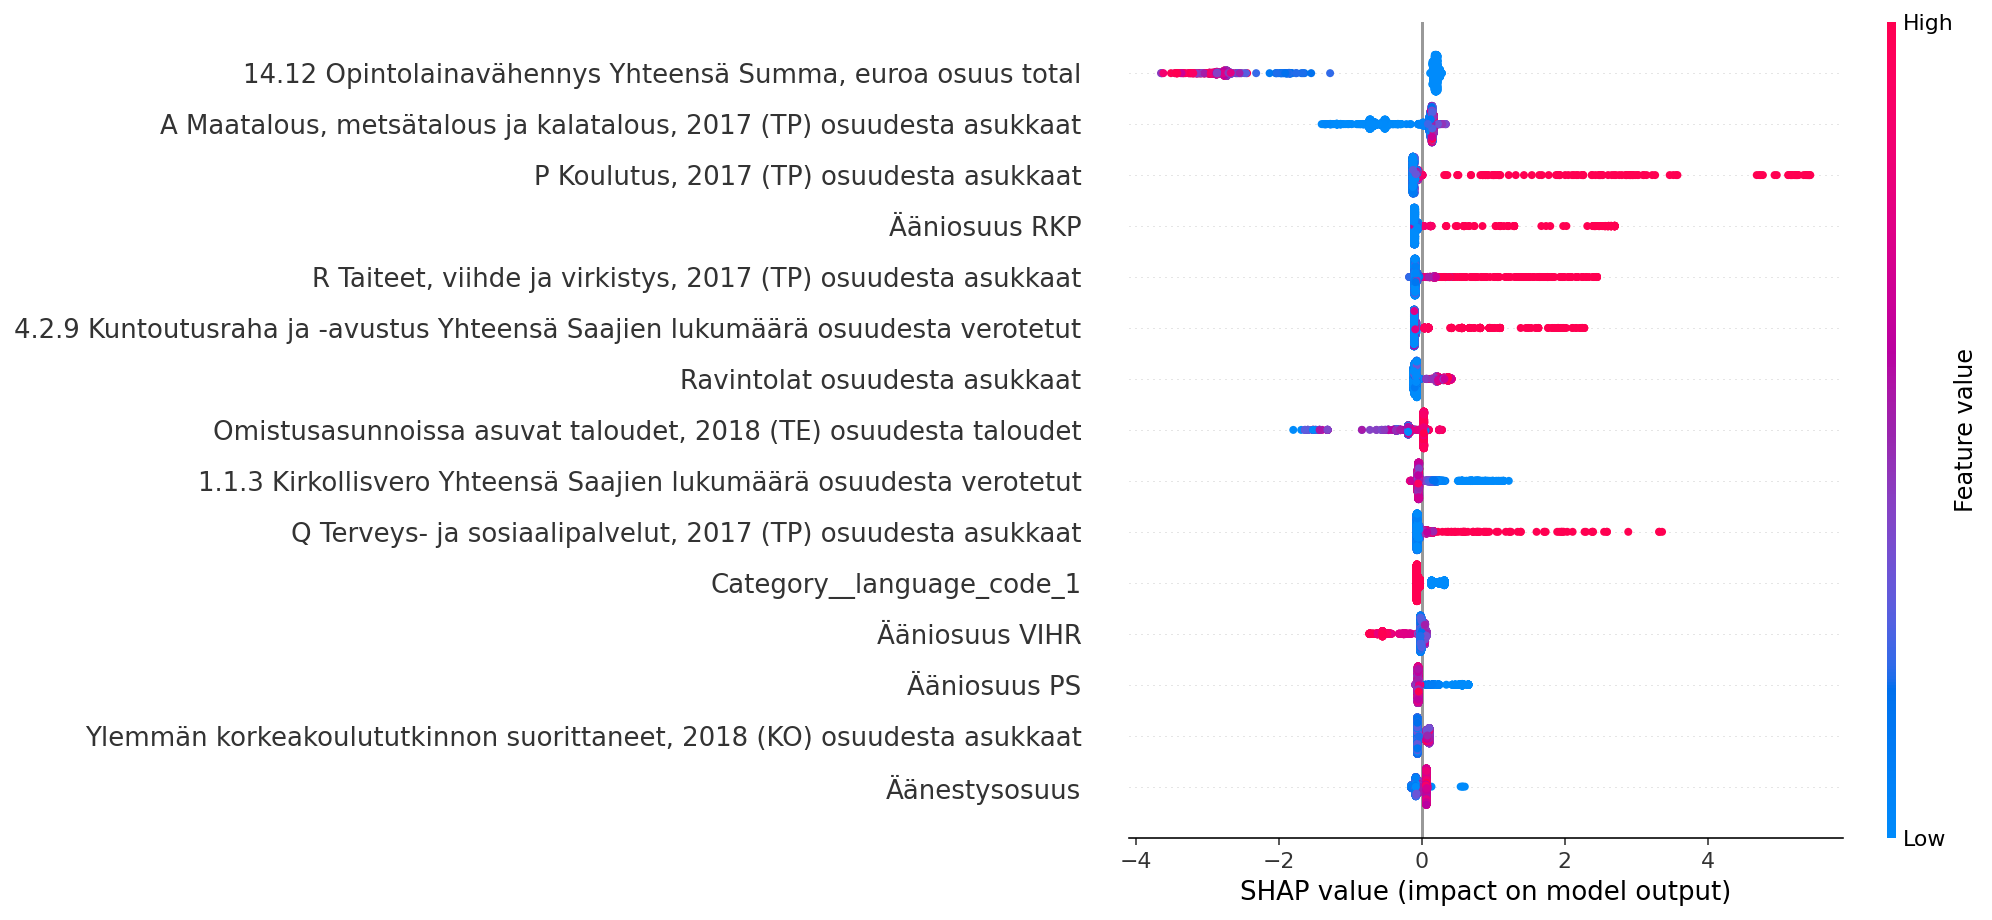

In [13]:
list_of_parties = ['VIHR', 'KOK', 'SDP', 'KD', 'KESK', 'RKP', 'PS', 'VAS']


included_col_start = 'Ääniosuus'
included_columns = create_target_columns(list_of_parties, included_col_start)
shap_index = 0
compare_to = data[(data['cluster']) == 1].copy()

shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


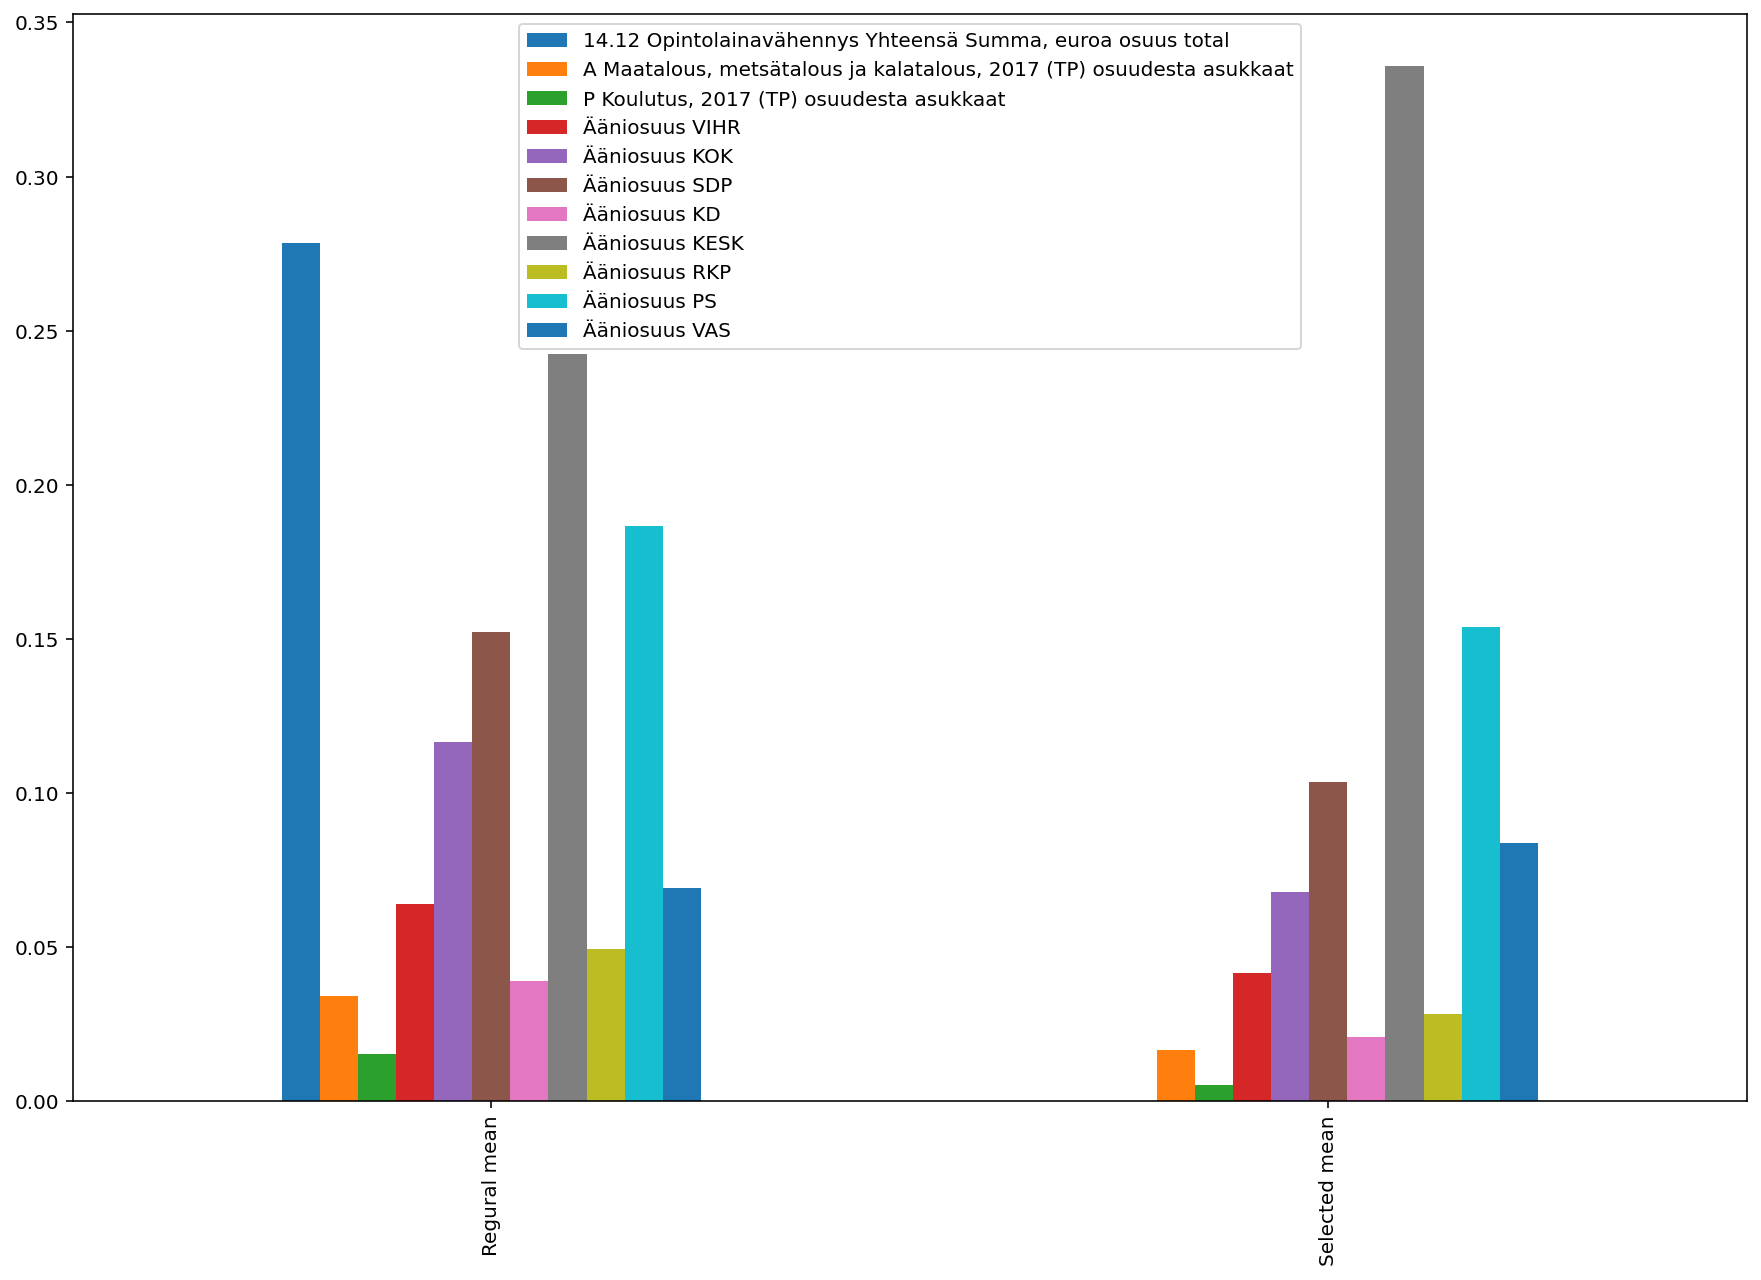

In [14]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=3, scaled=False)

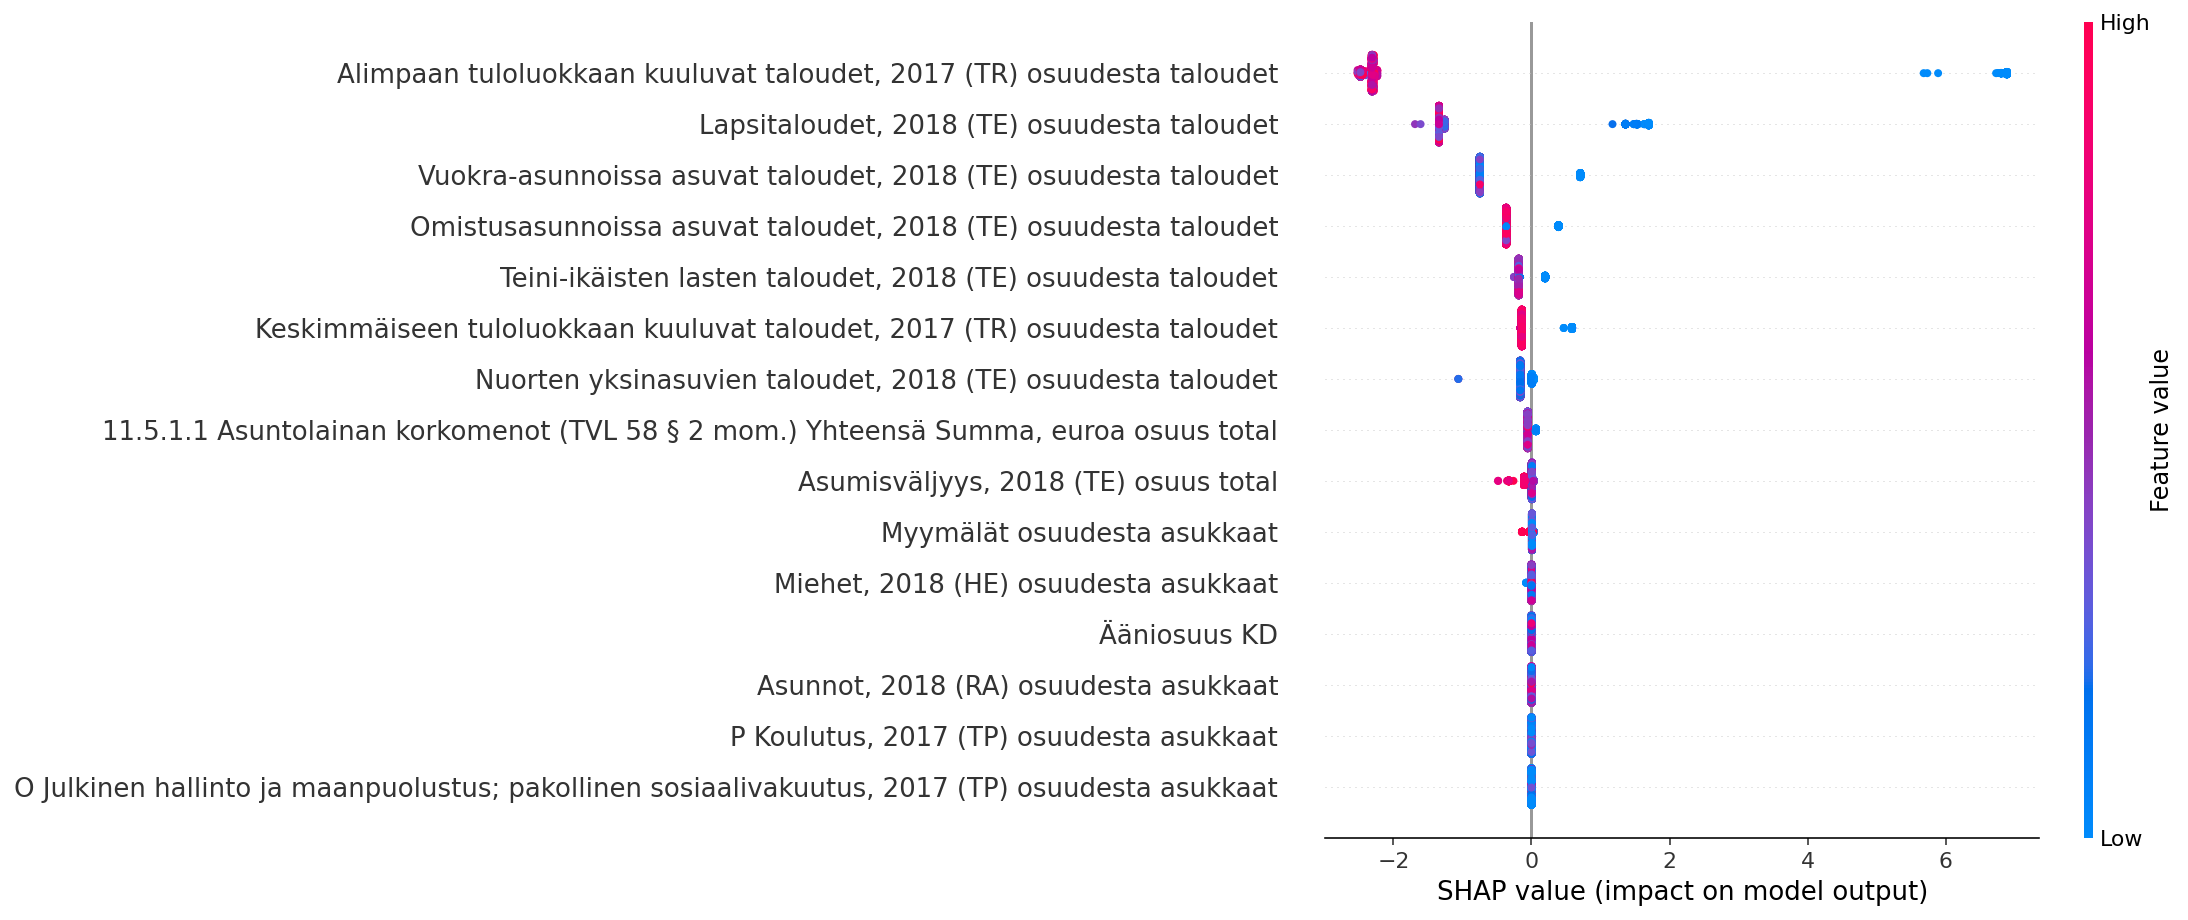

In [15]:

included_columns = []
shap_index = 1
compare_to = data[(data['cluster']) == 0].copy()

shap.summary_plot(shap_values[shap_index], X,  max_display=15)

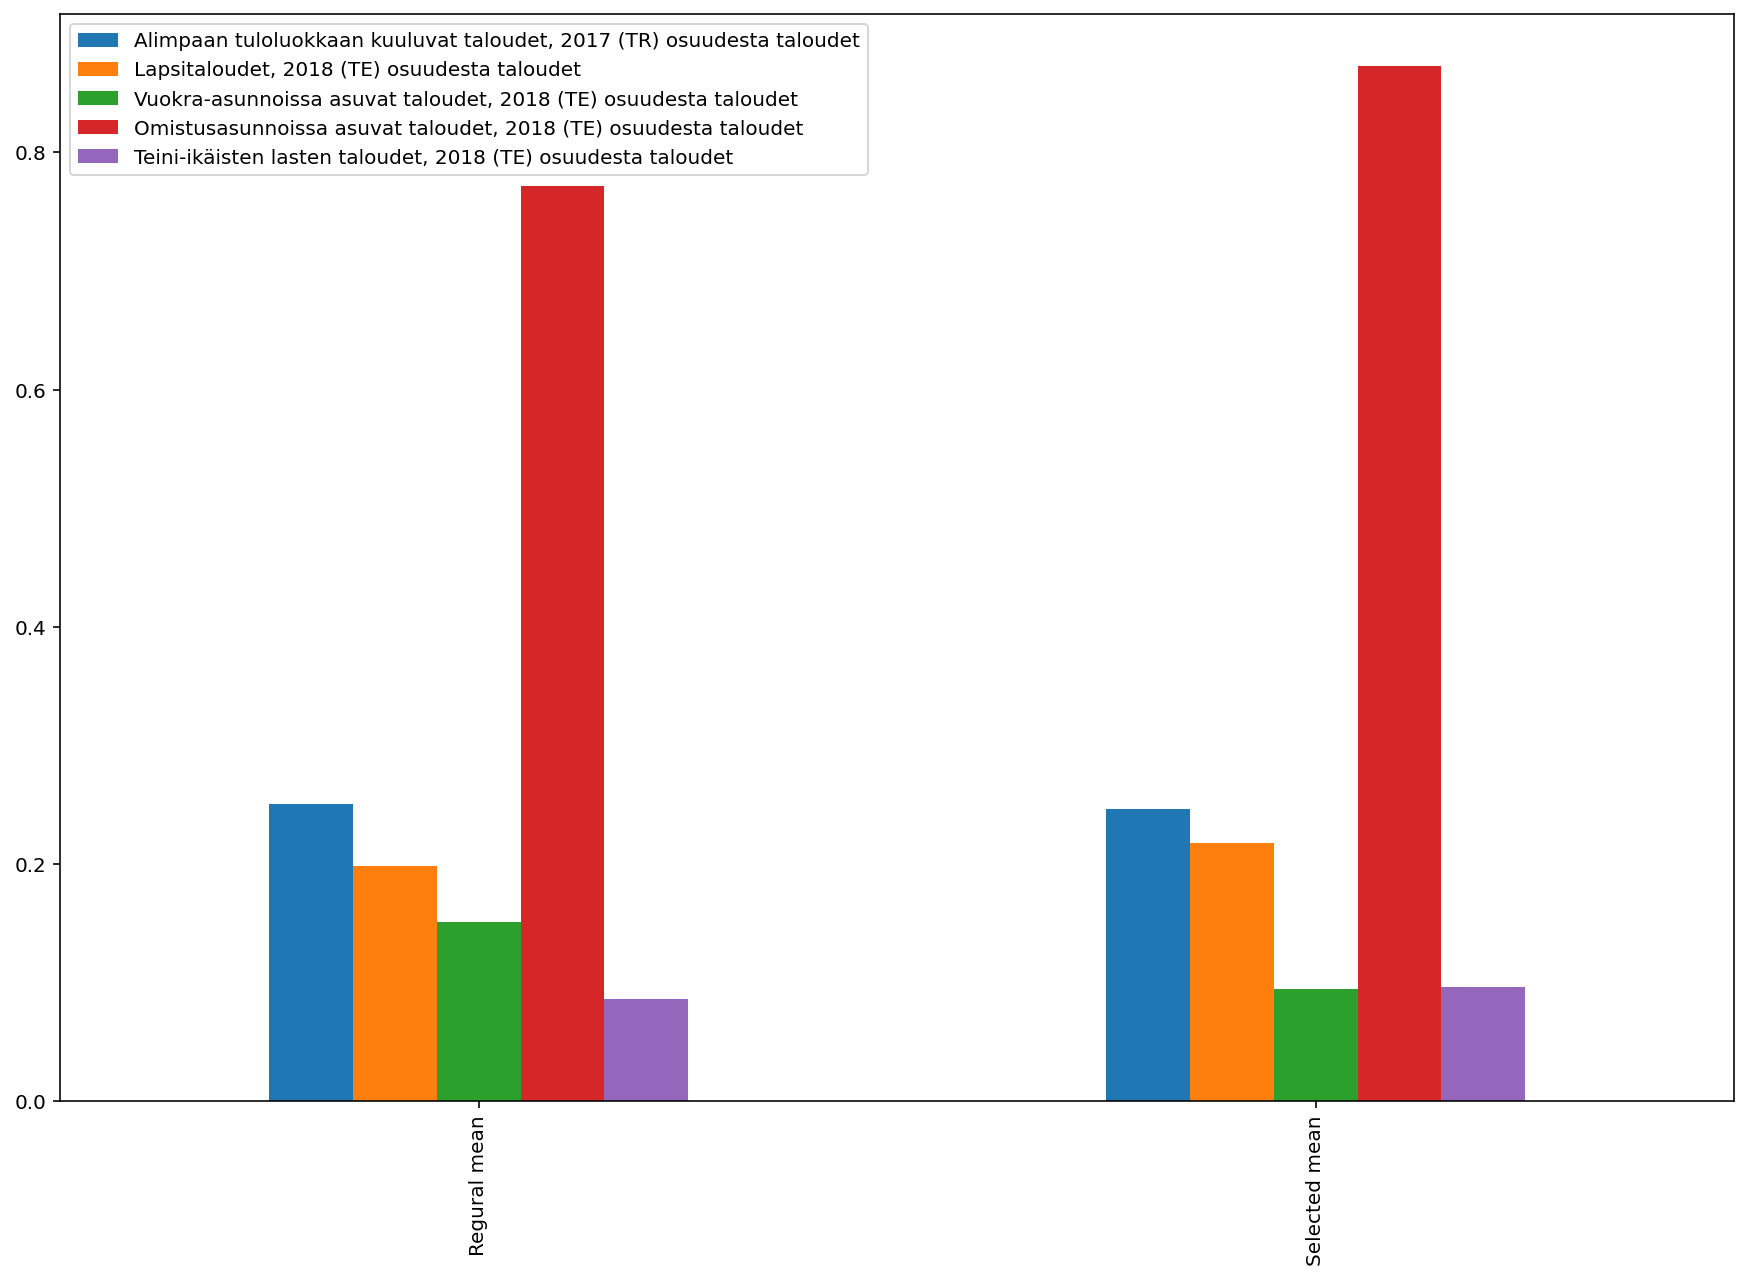

In [16]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=5, scaled=False)

In [17]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=6)
new_df.sample(5)

,Postinumero,postcode_name,muncipality_name,"Asukkaat yhteensä, 2018 (HE)",Suurin_puolue,"Lapsitaloudet, 2018 (TE) osuudesta taloudet","Teini-ikäisten lasten taloudet, 2018 (TE) osuudesta taloudet","Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet","Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet","Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet","Keskimmäiseen tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet"
1969,66850,JEPUA,Uusikaarlepyy,932.0,RKP,0.210396,0.066832,0.789604,0.188119,0.212871,0.621287
672,21750,NORRSKATA,Parainen,87.0,RKP,0.061224,0.000000,0.877551,0.081633,0.326531,0.530612
2122,70940,JÄNNEVIRTA,Siilinjärvi,563.0,KESK,0.316964,0.151786,0.986607,0.004464,0.138393,0.593750
301,07350,GÄDDRAG,Porvoo,72.0,RKP,0.212121,0.090909,0.969697,0.000000,0.060606,0.696970
668,21670,PÄRNÄINEN,Parainen,202.0,RKP,0.191919,0.080808,0.939394,0.050505,0.171717,0.535354


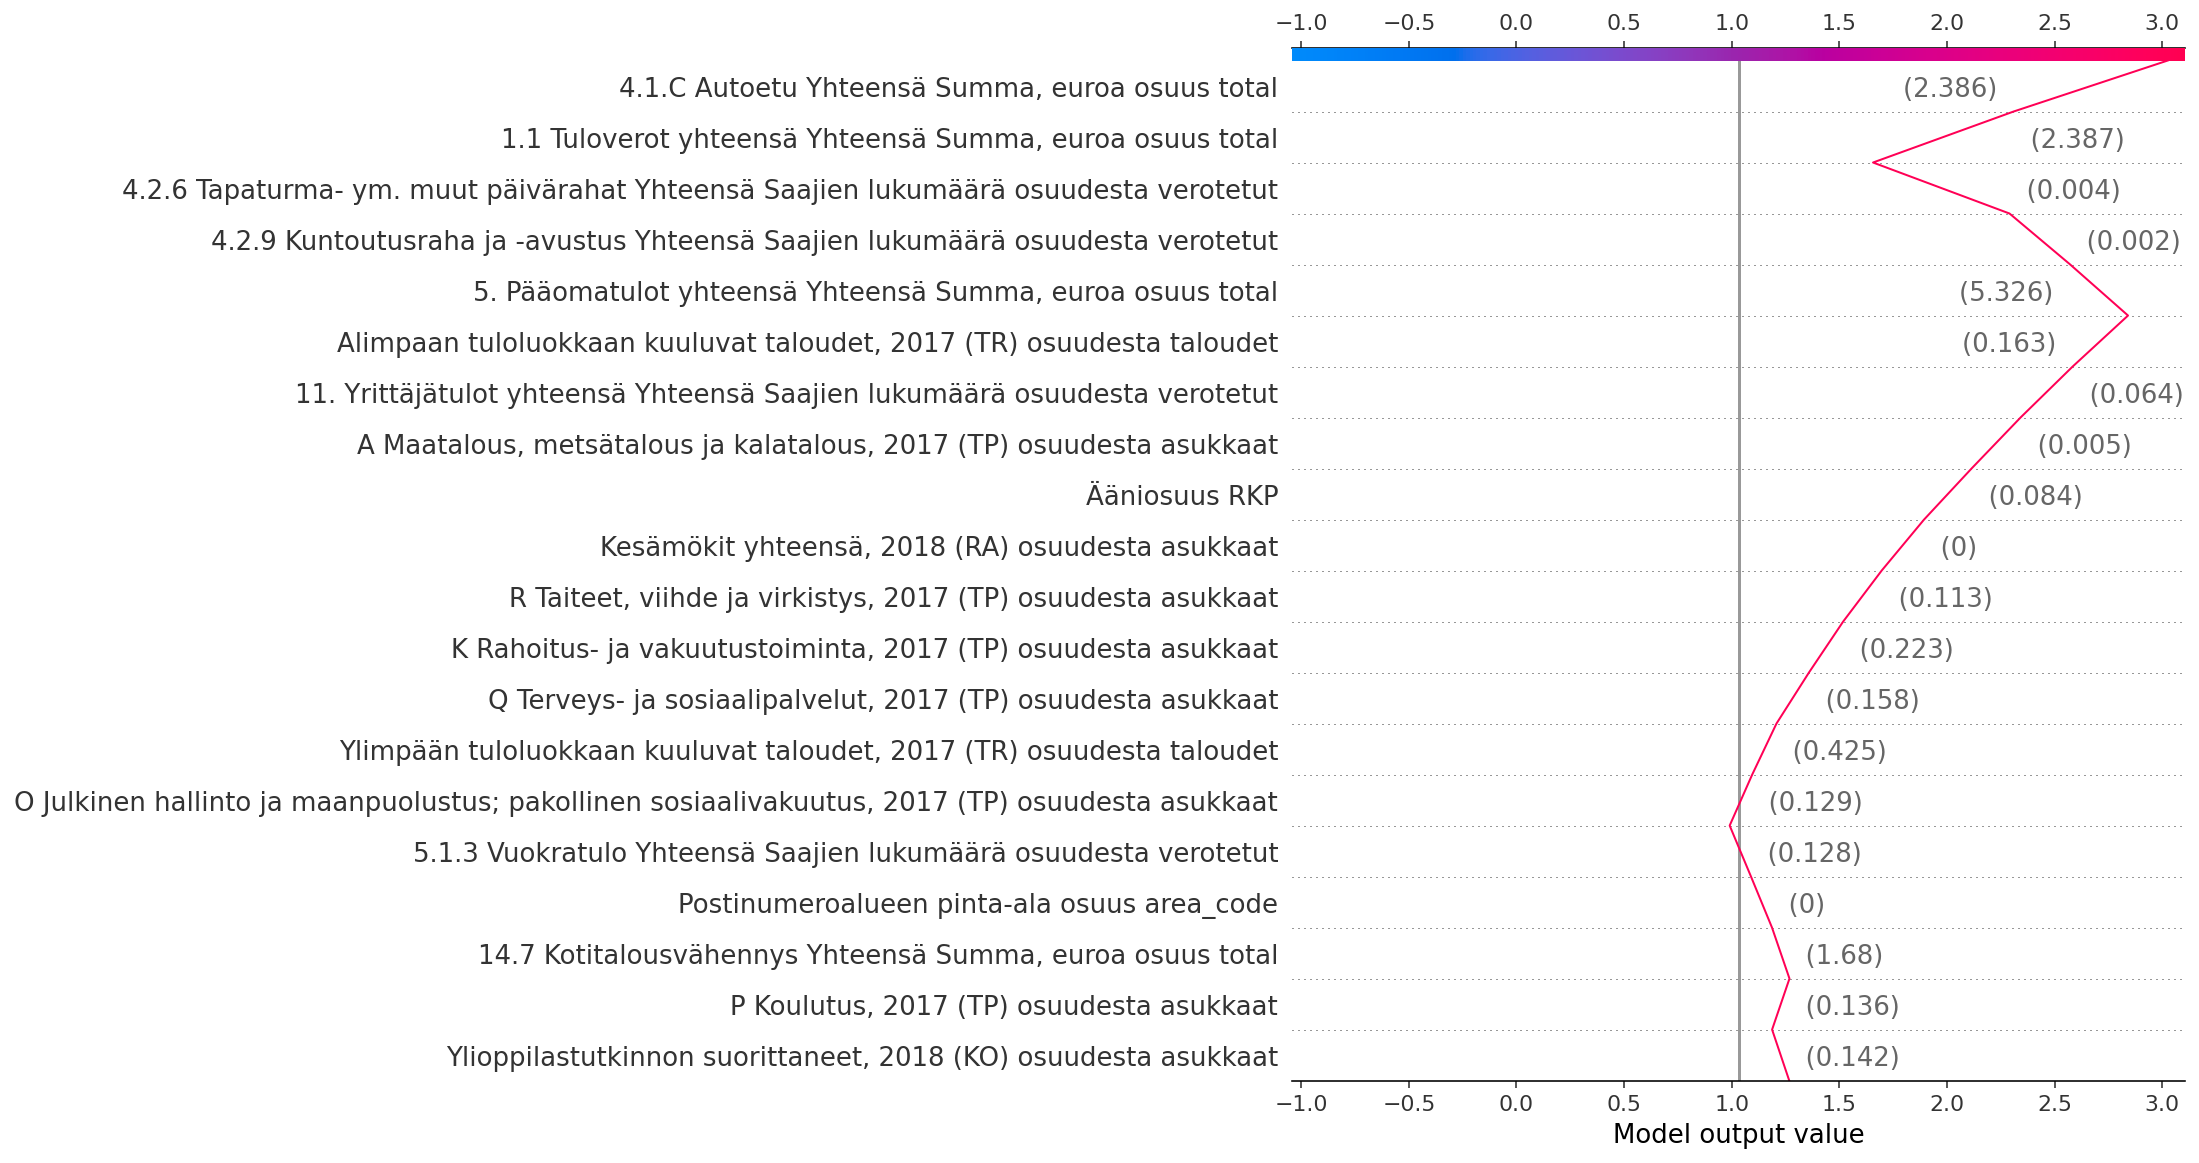

In [18]:
pnro = '02160'
id_col = 'Postinumero'
target='cluster'
idx = data[data[id_col]==pnro].index.item()
shap_index = data[data[id_col]==pnro][target].item()

shap.decision_plot(shap_expected_value[shap_index], shap_values[shap_index][idx], X)


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


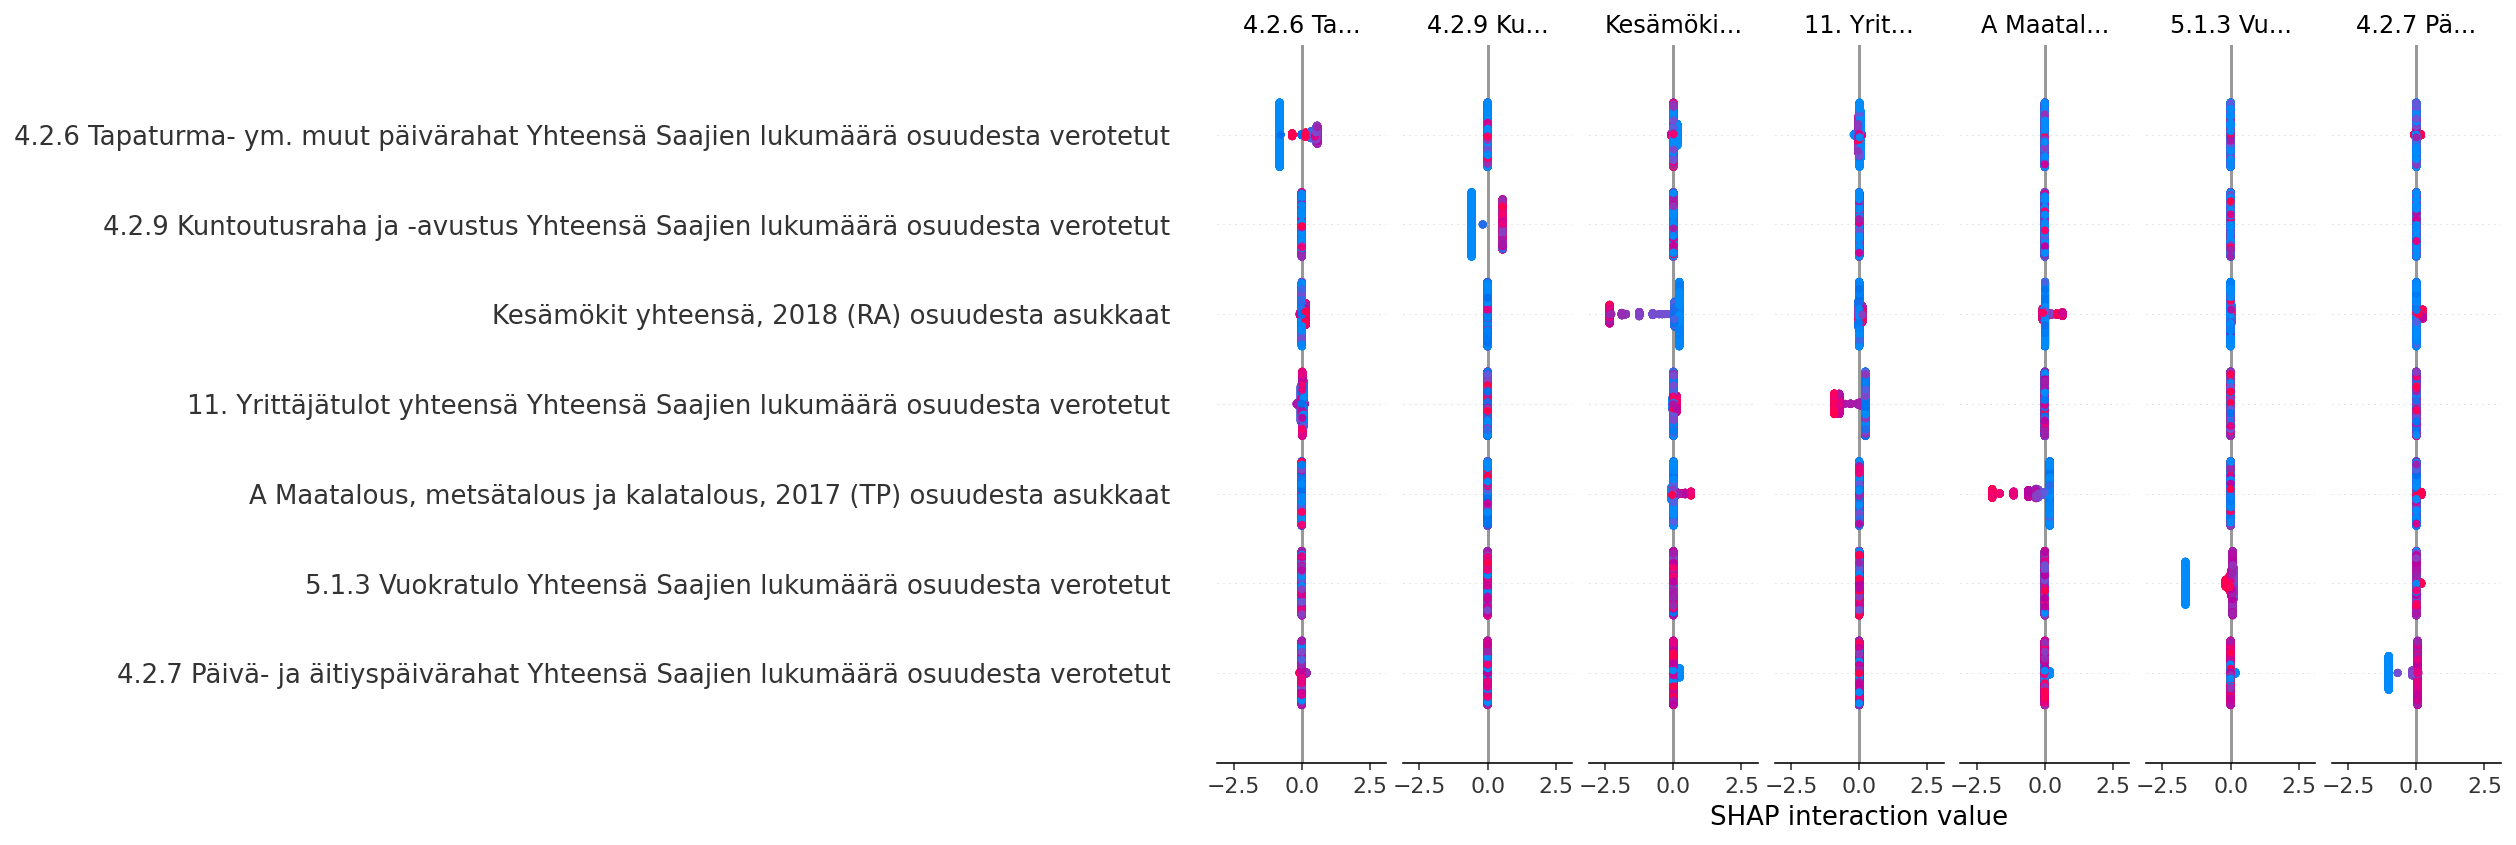

In [19]:
shap.summary_plot(shap_interaction_values[shap_index], X)